In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import scipy
from pandarallel import pandarallel


p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
h5 = '../cerberus_annot.h5'
h5_annot = 'cerberus_annot_triplets.h5'
h5_annot_mouse = '../../../mouse/lr_bulk/triplets/cerberus_annot_triplets.h5'
swan_file = '../swan/swan.p'
mouse_swan_file = '../../../mouse/lr_bulk/swan/swan.p'
ab = '../../talon/human_talon_abundance.tsv'
mouse_filt_ab = '../../../mouse/lr_bulk/cerberus/cerberus_filtered_abundance.tsv'
filt_ab = '../cerberus_filtered_abundance.tsv'
obs_col = 'sample'
min_tpm = 1
major_set = '../swan/isos_sample_gene_90.tsv'
major_set_mouse = '../swan/isos_sample_gene_90.tsv'
mm_tissues = get_mouse_match_samples()

In [73]:
ca = cerberus.read(h5_annot)

## calculate distance of each gene / sample pair to its centroid

In [8]:
def get_human_df(ca):
    # compute centroid for each  sample / gene pairing for the different sources
    source = 'sample_det'
    df = ca.triplets.loc[(ca.triplets.source == source)].copy(deep=True)
    df = cerberus.compute_simplex_coords(df, 'splicing_ratio')
    keep_cols = ['gname', 'gid', 'tss_ratio', 'tes_ratio', 'spl_ratio', 'n_iso']
    df = df[keep_cols]
    df = df.groupby(['gname', 'gid']).mean().reset_index()
    df = assign_sector(df)
    
    # only protein coding genes
    gene_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus', add_stable_gid=True)
    gene_df = gene_df[['gid_stable', 'biotype']]
    df = df.merge(gene_df, how='left', left_on='gid', right_on='gid_stable')
    df = df.loc[df.biotype=='protein_coding']
    
    return df

In [48]:
# centroids for each gene
cent_df = get_human_df(ca)
cent_df.loc[cent_df.gname=='BRK1']

,gname,gid,tss_ratio,tes_ratio,spl_ratio,n_iso,sector,gid_stable,biotype
1879,BRK1,ENSG00000254999,0.230769,0.461538,0.307692,3.8,mixed,ENSG00000254999,protein_coding


In [34]:
# individual genes
source = 'sample_det'
df = ca.triplets.loc[(ca.triplets.source == source)].copy(deep=True)
df = cerberus.compute_simplex_coords(df, 'splicing_ratio')
keep_cols = ['gname', 'gid', 'tss_ratio', 'tes_ratio', 'spl_ratio', 'n_iso', 'sample', 'gene_tpm']
df = df[keep_cols]
df = assign_sector(df)

# only protein coding genes
gene_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus', add_stable_gid=True)
gene_df = gene_df[['gid_stable', 'biotype']]
df = df.merge(gene_df, how='left', left_on='gid', right_on='gid_stable')
df = df.loc[df.biotype=='protein_coding']

In [35]:
df = df.merge(cent_df, how='left', on=['gname', 'gid'], suffixes=('', '_gene_avg'))

In [36]:
len(df.index)

545554

In [37]:
df.head()

,gname,gid,tss_ratio,tes_ratio,spl_ratio,n_iso,sample,gene_tpm,sector,gid_stable,biotype,tss_ratio_gene_avg,tes_ratio_gene_avg,spl_ratio_gene_avg,n_iso_gene_avg,sector_gene_avg,gid_stable_gene_avg,biotype_gene_avg
0,TSPAN6,ENSG00000000003,0.125000,0.625000,0.250000,18.0,caco2,347.757385,tes,ENSG00000000003,protein_coding,0.164188,0.590456,0.245356,8.560976,tes,ENSG00000000003,protein_coding
1,DPM1,ENSG00000000419,0.121951,0.487805,0.390244,11.0,caco2,126.812943,mixed,ENSG00000000419,protein_coding,0.168068,0.277963,0.553969,6.960000,splicing,ENSG00000000419,protein_coding
2,SCYL3,ENSG00000000457,0.200000,0.400000,0.400000,4.0,caco2,10.705085,mixed,ENSG00000000457,protein_coding,0.273306,0.389927,0.336767,2.250000,mixed,ENSG00000000457,protein_coding
3,C1orf112,ENSG00000000460,0.400000,0.200000,0.400000,4.0,caco2,17.822382,mixed,ENSG00000000460,protein_coding,0.361802,0.334081,0.304117,3.413043,mixed,ENSG00000000460,protein_coding
4,FUCA2,ENSG00000001036,0.135135,0.540541,0.324324,11.0,caco2,261.958191,tes,ENSG00000001036,protein_coding,0.168460,0.434446,0.397094,7.142857,mixed,ENSG00000001036,protein_coding


In [52]:
# compute distances
pandarallel.initialize(nb_workers=8, verbose=1)
df['dist'] = df.parallel_apply(simplex_dist_x,
                               args=('', '_gene_avg'),
                               axis=1)
df.dist = df.dist.fillna(0)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1296: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1296: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1296: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1296: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1296: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1296: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js

In [53]:
df.head()

,gname,gid,tss_ratio,tes_ratio,spl_ratio,n_iso,sample,gene_tpm,sector,gid_stable,biotype,tss_ratio_gene_avg,tes_ratio_gene_avg,spl_ratio_gene_avg,n_iso_gene_avg,sector_gene_avg,gid_stable_gene_avg,biotype_gene_avg,dist,z_score
0,TSPAN6,ENSG00000000003,0.125000,0.625000,0.250000,18.0,caco2,347.757400,tes,ENSG00000000003,protein_coding,0.164188,0.590456,0.245356,8.560976,tes,ENSG00000000003,protein_coding,0.039850,NaN
1,DPM1,ENSG00000000419,0.121951,0.487805,0.390244,11.0,caco2,126.812940,mixed,ENSG00000000419,protein_coding,0.168068,0.277963,0.553969,6.960000,splicing,ENSG00000000419,protein_coding,0.153413,NaN
2,SCYL3,ENSG00000000457,0.200000,0.400000,0.400000,4.0,caco2,10.705085,mixed,ENSG00000000457,protein_coding,0.273306,0.389927,0.336767,2.250000,mixed,ENSG00000000457,protein_coding,0.065119,NaN
3,C1orf112,ENSG00000000460,0.400000,0.200000,0.400000,4.0,caco2,17.822382,mixed,ENSG00000000460,protein_coding,0.361802,0.334081,0.304117,3.413043,mixed,ENSG00000000460,protein_coding,0.110722,NaN
4,FUCA2,ENSG00000001036,0.135135,0.540541,0.324324,11.0,caco2,261.958200,tes,ENSG00000001036,protein_coding,0.168460,0.434446,0.397094,7.142857,mixed,ENSG00000001036,protein_coding,0.075143,NaN


In [54]:
df.to_csv('sample_det_vs_gene_avg_dist.tsv', sep='\t', index=False)

## Results

In [18]:
df = pd.read_csv('sample_det_vs_gene_avg_dist.tsv', sep='\t')

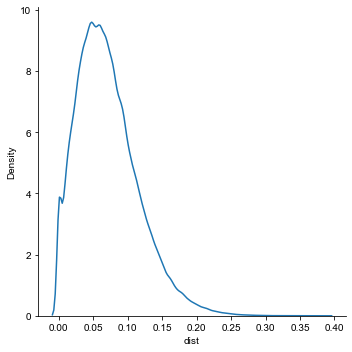

In [19]:
sns.displot(data=df, x='dist', kind='kde')

In [20]:
# calc z scores and use these to quantiy
df['z_score'] = st.zscore(df.dist.tolist())

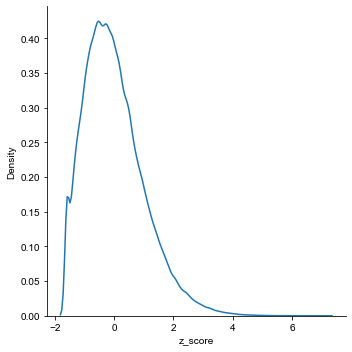

In [21]:
sns.displot(data=df, x='z_score', kind='kde')

In [22]:
# there were a bunch of genes w/ null dists which I changed to 0
temp = df.loc[df.dist.isnull()]
print(len(temp.index))
print(len(temp.loc[temp.tss_ratio == temp.tss_ratio_gene_avg].index))
temp.loc[temp.tss_ratio != temp.tss_ratio_gene_avg]

0
0


,gname,gid,tss_ratio,tes_ratio,spl_ratio,n_iso,sample,gene_tpm,sector,gid_stable,biotype,tss_ratio_gene_avg,tes_ratio_gene_avg,spl_ratio_gene_avg,n_iso_gene_avg,sector_gene_avg,gid_stable_gene_avg,biotype_gene_avg,dist,z_score


In [23]:
# ca.triplets.loc[(ca.triplets.gname=='PMS2P4')&(ca.triplets.source=='sample_det')]

In [26]:
len(df.loc[(df.z_score > 3), 'gid'].unique())

2896

In [68]:
# look for genes that are 
# - in the 16 cell lines
# - TFs? 
# - high z-score
ljungman_datasets = get_sample_datasets(sample='ljungman', groupby='sample')
df.loc[(df.z_score > 3)&(df['sample'].isin(ljungman_datasets))].sort_values(by='z_score', ascending=False).head(20)


,gname,gid,tss_ratio,tes_ratio,spl_ratio,n_iso,sample,gene_tpm,sector,gid_stable,biotype,tss_ratio_gene_avg,tes_ratio_gene_avg,spl_ratio_gene_avg,n_iso_gene_avg,sector_gene_avg,gid_stable_gene_avg,biotype_gene_avg,dist,z_score
32897,CTNNB1,ENSG00000168036,0.111111,0.111111,0.777778,7.0,mcf10a,76.340820,splicing,ENSG00000168036,protein_coding,0.405801,0.309722,0.284477,11.740000,mixed,ENSG00000168036,protein_coding,0.358551,6.503623
112232,SIDT2,ENSG00000149577,0.125000,0.125000,0.750000,6.0,imr90,132.612750,splicing,ENSG00000149577,protein_coding,0.373101,0.361839,0.265060,4.000000,mixed,ENSG00000149577,protein_coding,0.350336,6.318072
271544,DBF4,ENSG00000006634,0.111111,0.111111,0.777778,7.0,huvec,29.571903,splicing,ENSG00000006634,protein_coding,0.292082,0.405976,0.301941,6.208333,mixed,ENSG00000006634,protein_coding,0.346405,6.229277
519917,DPP7,ENSG00000176978,0.461538,0.230769,0.307692,2.0,hepg2,2.325026,mixed,ENSG00000176978,protein_coding,0.136518,0.088197,0.775284,19.000000,splicing,ENSG00000176978,protein_coding,0.339588,6.075287
2580,C17orf75,ENSG00000108666,0.166667,0.166667,0.666667,4.0,caco2,48.730656,splicing,ENSG00000108666,protein_coding,0.277786,0.498898,0.223315,4.700000,mixed,ENSG00000108666,protein_coding,0.328879,5.833373
275875,SRRM1,ENSG00000133226,0.071429,0.071429,0.857143,12.0,huvec,77.752750,splicing,ENSG00000133226,protein_coding,0.191116,0.369284,0.439600,10.580000,mixed,ENSG00000133226,protein_coding,0.321677,5.670686
34162,IST1,ENSG00000182149,0.111111,0.111111,0.777778,7.0,mcf10a,107.945880,splicing,ENSG00000182149,protein_coding,0.335937,0.326099,0.337965,11.100000,mixed,ENSG00000182149,protein_coding,0.318986,5.609903
89921,FGF2,ENSG00000138685,0.137255,0.823529,0.039216,6.0,hmec,41.009720,tes,ENSG00000138685,protein_coding,0.299994,0.423923,0.276083,1.730769,mixed,ENSG00000138685,protein_coding,0.313296,5.481379
398700,RGL2,ENSG00000237441,0.125000,0.125000,0.750000,6.0,ocily7,47.322968,splicing,ENSG00000237441,protein_coding,0.492805,0.155198,0.351997,6.088889,mixed,ENSG00000237441,protein_coding,0.310038,5.407780
113971,COL3A1,ENSG00000168542,0.041096,0.082192,0.876712,51.0,imr90,8789.470000,splicing,ENSG00000168542,protein_coding,0.182324,0.336280,0.481396,13.041667,mixed,ENSG00000168542,protein_coding,0.307697,5.354896


In [4]:
ca = cerberus.read(h5_annot)

In [9]:
# add centroid as coord
cent_df = get_human_df(ca)
cent_df['source'] = 'sample_det_centroid'
ca.triplets = pd.concat([ca.triplets, cent_df], axis=0)
ca.triplets.tail()

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm,tss_ratio,tes_ratio,spl_ratio,sector,gid_stable,biotype
26776,sample_det_centroid,ENSG00000203995,NaN,NaN,NaN,1.000000,NaN,ZYG11A,NaN,NaN,0.333333,0.333333,0.333333,simple,ENSG00000203995,protein_coding
26777,sample_det_centroid,ENSG00000162378,NaN,NaN,NaN,1.055556,NaN,ZYG11B,NaN,NaN,0.329966,0.345118,0.324916,mixed,ENSG00000162378,protein_coding
26778,sample_det_centroid,ENSG00000159840,NaN,NaN,NaN,6.782609,NaN,ZYX,NaN,NaN,0.417264,0.155932,0.426805,mixed,ENSG00000159840,protein_coding
26779,sample_det_centroid,ENSG00000074755,NaN,NaN,NaN,1.000000,NaN,ZZEF1,NaN,NaN,0.333333,0.333333,0.333333,simple,ENSG00000074755,protein_coding
26780,sample_det_centroid,ENSG00000036549,NaN,NaN,NaN,11.080000,NaN,ZZZ3,NaN,NaN,0.263455,0.373735,0.362810,mixed,ENSG00000036549,protein_coding


In [14]:
def plot_simplex_here(ca, gene):
    # human
    c_dict, order = get_biosample_colors()
    c_dict[np.nan] = 'k'
    mmap = {'v40': '*', 'v29': 'x', 'obs_det': '^', 'cerberus': '2', 'sample_det_centroid': 's'} 
    df = ca.plot_simplex(top='splicing_ratio', 
                gene=gene,
                hue='sample',
                cmap=c_dict,
                size='gene_tpm', 
                log_size=True,
                sectors=True,
                marker_style='source',
                mmap=mmap,
                legend=False,
                jitter=True,
                subset={'source': ['v40', 'obs_det', 'sample_det', 'sample_det_centroid']},
                size_scale=0.5,
                fname='figures/simplex_{}_centroid_vs_sample.pdf'.format(gene.lower()))

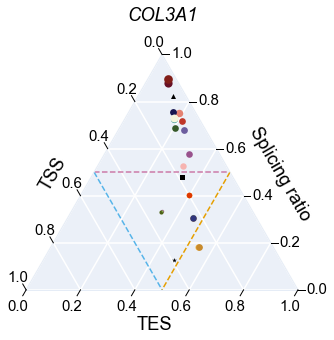

In [15]:
plot_simplex_here(ca, 'COL3A1')

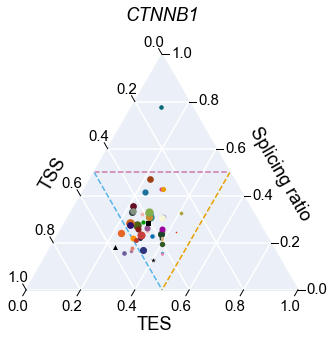

In [16]:
plot_simplex_here(ca, 'CTNNB1')

In [84]:
ca.triplets.head()

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm,tss_ratio,tes_ratio,spl_ratio
0,lapa,ENSG00000000003,2.0,6.0,10.0,30.0,2.5,TSPAN6,NaN,NaN,0.190476,0.571429,0.238095
1,lapa,ENSG00000000005,2.0,2.0,2.0,2.0,1.0,TNMD,NaN,NaN,0.400000,0.400000,0.200000
2,lapa,ENSG00000000419,2.0,4.0,9.0,16.0,3.0,DPM1,NaN,NaN,0.222222,0.444444,0.333333
3,lapa,ENSG00000000457,3.0,5.0,6.0,8.0,1.5,SCYL3,NaN,NaN,0.315789,0.526316,0.157895
4,lapa,ENSG00000000460,3.0,4.0,7.0,15.0,2.0,C1orf112,NaN,NaN,0.333333,0.444444,0.222222
